In [1]:
%matplotlib inline

import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.datasets import load_breast_cancer, load_boston

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import preprocessing
from sklearn import utils


# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import itertools


In [2]:
d = pd.read_csv('data/cleaned_data_together.csv')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)

In [3]:
df['MOY'] =df['DateTime']
df['WOY'] =df['DateTime']
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

In [4]:
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))
df['WOY'] = df['WOY'].apply(lambda x : woy(x))

In [5]:
df['one_week_back_temp'] = df['Temp'].shift(7).fillna(method= 'backfill')
df['two_week_back_temp'] = df['Temp'].shift(14).fillna(method= 'backfill')
df['three_week_back_temp'] = df['Temp'].shift(21).fillna(method= 'backfill')
df['four_week_back_temp'] = df['Temp'].shift(28).fillna(method= 'backfill')

In [6]:
df['one_back'] = df['Henry Hub Price $/MMBtu'].shift(1).fillna(method= 'backfill')
df['two_back'] = df['Henry Hub Price $/MMBtu'].shift(2).fillna(method= 'backfill')
df['three_back'] = df['Henry Hub Price $/MMBtu'].shift(3).fillna(method= 'backfill')
df['four_back'] = df['Henry Hub Price $/MMBtu'].shift(4).fillna(method= 'backfill')
df['five_back'] = df['Henry Hub Price $/MMBtu'].shift(5).fillna(method= 'backfill')

In [7]:
df['back'] = df['one_back']*0.2 + df['two_back']*0.2 + df['three_back']*0.2 + df['four_back']*0.2 + df['five_back']*0.2

In [8]:
df['con_sto_diff'] = df['Storage BCFE'] - (df['Consumption MMCF']/1000)

In [9]:
df.head()

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,MOY,WOY,...,two_week_back_temp,three_week_back_temp,four_week_back_temp,one_back,two_back,three_back,four_back,five_back,back,con_sto_diff
0,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,1,53,...,26.0317,26.0317,26.0317,5.82,5.82,5.82,5.82,5.82,5.820,1450.48
1,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,1,53,...,26.0317,26.0317,26.0317,5.82,5.82,5.82,5.82,5.82,5.820,1450.48
2,2010-01-03,5.82,23.5537,2197157.0,3117.0,255035.0,1666520.0,3,1,53,...,26.0317,26.0317,26.0317,5.82,5.82,5.82,5.82,5.82,5.820,1450.48
3,2010-01-04,6.09,23.2831,2197157.0,3117.0,255035.0,1666520.0,4,1,1,...,26.0317,26.0317,26.0317,5.82,5.82,5.82,5.82,5.82,5.820,1450.48
4,2010-01-05,6.19,24.5469,2197157.0,3117.0,255035.0,1666520.0,5,1,1,...,26.0317,26.0317,26.0317,6.09,5.82,5.82,5.82,5.82,5.874,1450.48


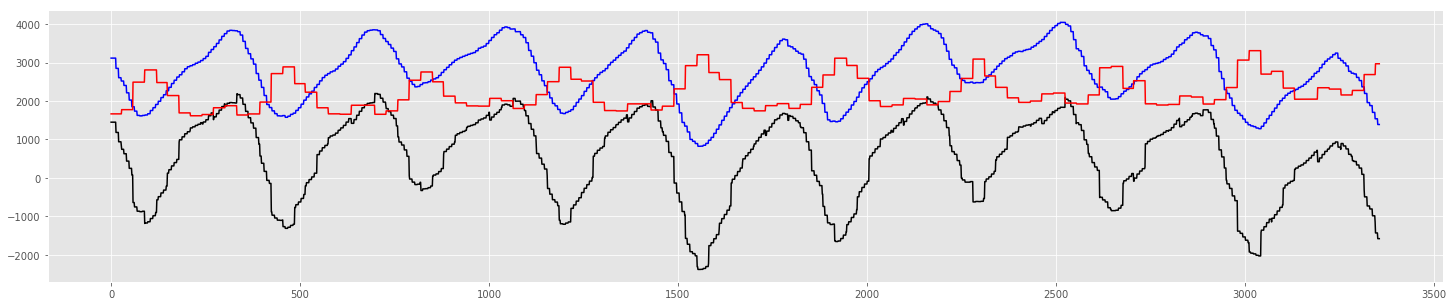

In [10]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(df.con_sto_diff, color='black')
axs.plot(df['Storage BCFE'], color='blue')
axs.plot(df['Consumption MMCF']/1000, color='red')
#axs.set_xlim([0, 100])
#axs.set_ylim([2.5, 3.5])
plt.show()

In [11]:
DateTime = df.pop('DateTime').values

In [12]:
y = df.pop('Henry Hub Price $/MMBtu').values

In [13]:
small_df= df[1600:2900]

In [14]:
small_y = y[1600:2900]

In [15]:
Xs = small_df.values

In [16]:
size = int(len(Xs) * 0.75)
X_train, X_test, y_train, y_test = Xs[0:size], Xs[size:len(Xs)], small_y[0:size], small_y[size:len(y)]

In [17]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,19)))
    yhat = output[0]
    predictions.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.01752


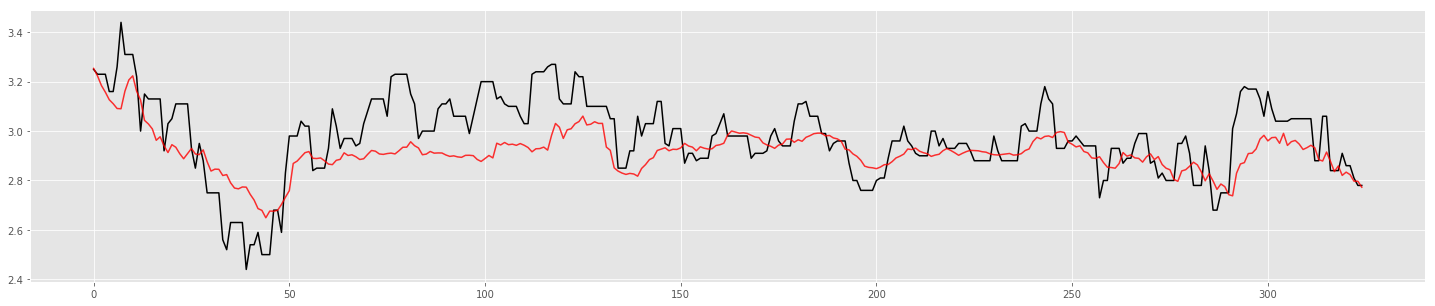

In [18]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

In [19]:
df.columns

Index(['Temp', 'Production MMCF', 'Storage BCFE', 'Reserves BCFE',
       'Consumption MMCF', 'DOY', 'MOY', 'WOY', 'one_week_back_temp',
       'two_week_back_temp', 'three_week_back_temp', 'four_week_back_temp',
       'one_back', 'two_back', 'three_back', 'four_back', 'five_back', 'back',
       'con_sto_diff'],
      dtype='object')

In [64]:
lst1 = ['Temp',
       'DOY', 'MOY', 'WOY', 'one_week_back_temp',
       'two_week_back_temp', 'three_week_back_temp', 'four_week_back_temp',
       'con_sto_diff']

In [65]:
Xs2 = small_df[lst1].values

In [66]:
size = int(len(Xs) * 0.75)
X_train, X_test, y_train, y_test = Xs2[0:size], Xs2[size:len(Xs2)], small_y[0:size], small_y[size:len(y)]

In [68]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,9)))
    yhat = output[0]
    predictions.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.25623


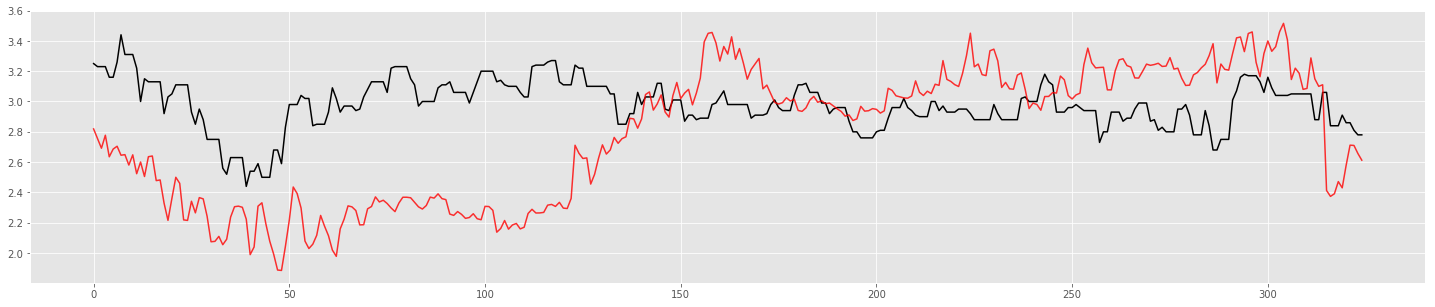

In [69]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

In [70]:
model = GradientBoostingRegressor()

param_grid = {
    'max_depth': [80, 90, 100], #, 110
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [3, 4, 5, 10], #, 50, 90
    'max_leaf_nodes': [2, 4, 8],
    'min_samples_split': [8, 10, 12, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200, 500] #, 300, 1000, 2000
}
clf = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
clf.fit(X_train,y_train)
print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

Accuracy score: -11.3


In [71]:
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=90, max_features=2,
             max_leaf_nodes=2, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [88]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions11 = list()
gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=90, max_features=5,
             max_leaf_nodes=2, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
gbr_fit = gbr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = gbr_fit.predict(X_test[t].reshape((1,9)))
    yhat = output[0]
    predictions11.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions11)
error = mean_squared_error(y_test, predictions11)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.31786


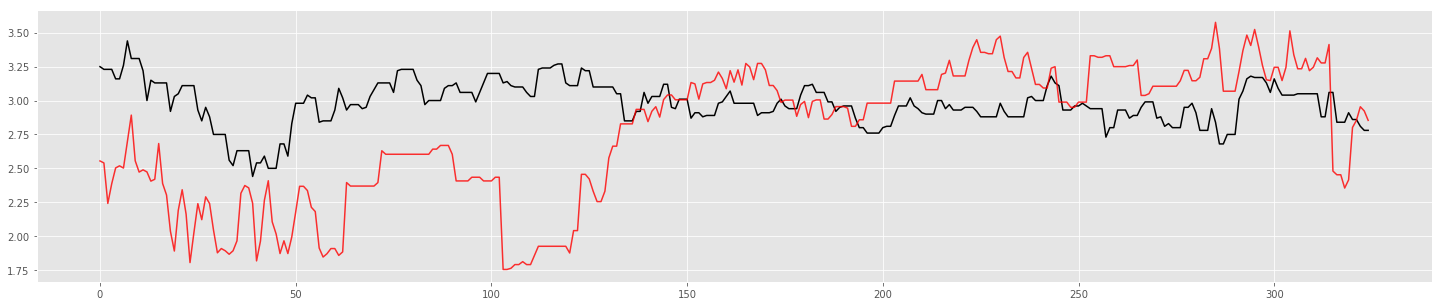

In [89]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions11, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

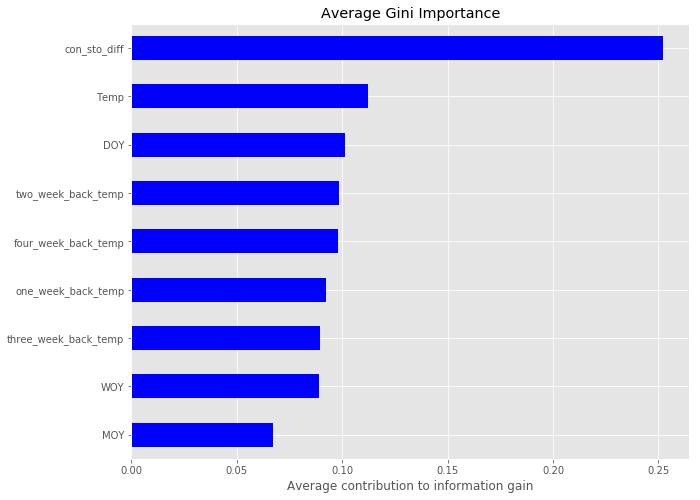

In [90]:
# Plot the feature importance
feat_scores = pd.Series(rfr.feature_importances_,
                           index=small_df[lst1].columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [91]:
lst2 = ['Temp', 'Production MMCF', 'Reserves BCFE',
       'DOY', 'MOY', 'WOY', 'one_week_back_temp',
       'two_week_back_temp', 'three_week_back_temp', 'four_week_back_temp',
       'back',
       'con_sto_diff']

In [92]:
Xs3 = small_df[lst2].values

In [93]:
size = int(len(Xs) * 0.75)
X_train, X_test, y_train, y_test = Xs3[0:size], Xs3[size:len(Xs3)], small_y[0:size], small_y[size:len(y)]

In [106]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,12)))
    yhat = output[0]
    predictions.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.03747


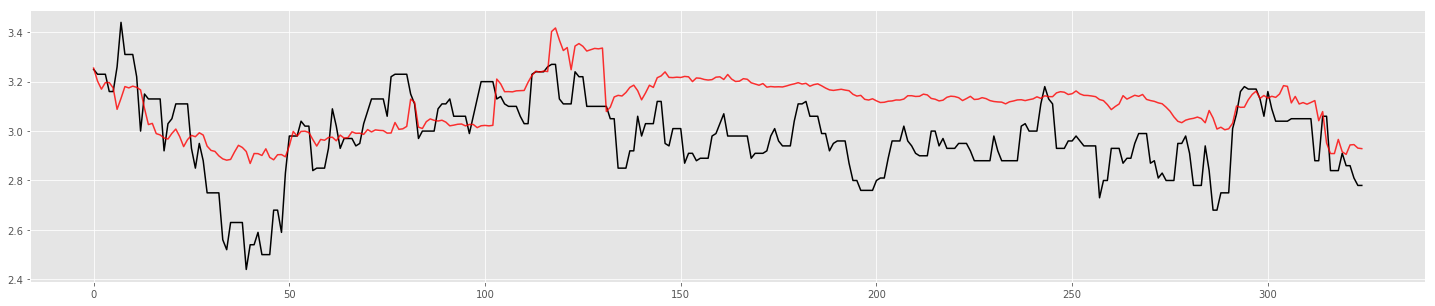

In [107]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

In [161]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions11 = list()
gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=90, max_features=5,
             max_leaf_nodes=2, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
gbr_fit = gbr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = gbr_fit.predict(X_test[t].reshape((1,12)))
    yhat = output[0]
    predictions11.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions11)
error = mean_squared_error(y_test, predictions11)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.02485


In [162]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in range(len(model.estimators_)):
            preds.append(model.predict(X[x].reshape((1,12))))
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [163]:
err_down, err_up = pred_ints(gbr, X_test, percentile=90)
 
truth = y_test
correct = 0.
for i, val in enumerate(truth):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print (correct/len(truth))

0.0


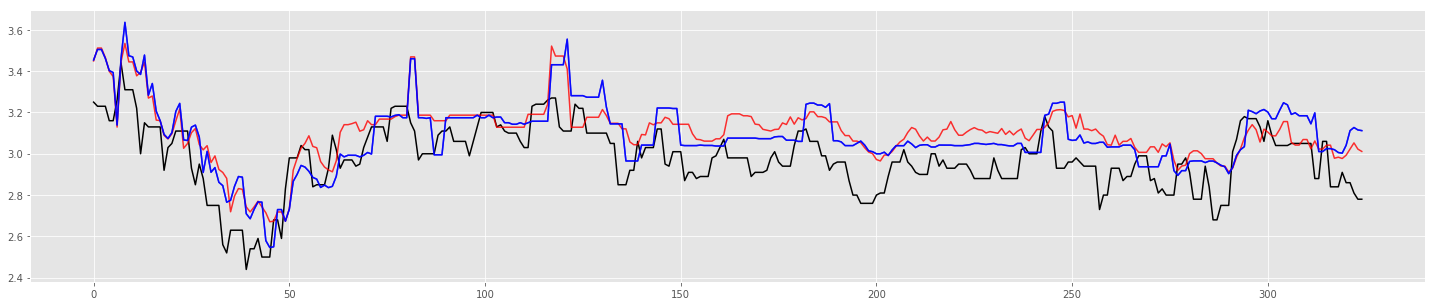

In [166]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
axs.plot(err_down, color='blue', alpha = 0.8)
axs.plot(err_up, color='blue', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

In [135]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions = list()
err_down = []
err_up = []
gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=90, max_features=5,
             max_leaf_nodes=2, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
gbr_fit = gbr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = gbr_fit.predict(X_test[t].reshape((1,12)))
    yhat = output[0]
    predictions.append(yhat)
    err_down.append(np.percentile(predictions, (100 - 95) / 2. ))
    err_up.append(np.percentile(predictions, 100 - (100 - 95) / 2.))
    
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.02809


In [147]:
len(gbr_fit.estimators_)

500

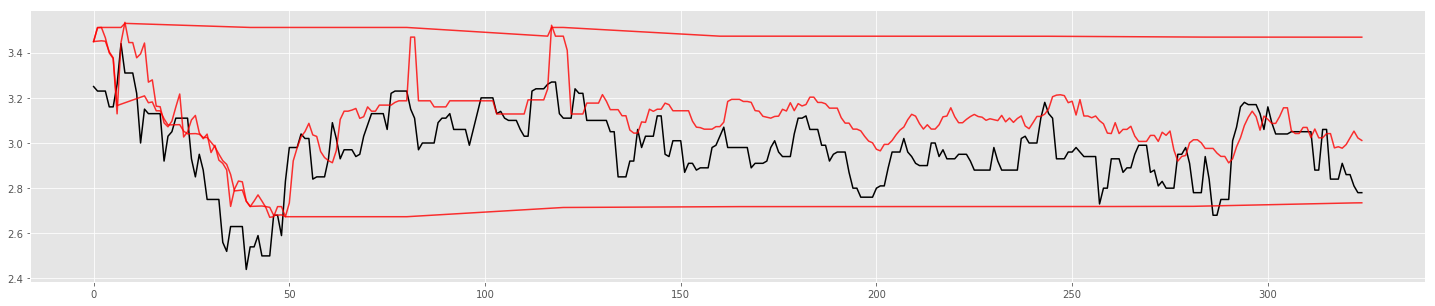

In [139]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
axs.plot(err_down, color='red', alpha = 0.8)
axs.plot(err_up, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

In [167]:
trainsize = 400
idx = range(size)
#shuffle the data
np.random.shuffle(idx)
rf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=1)
rf.fit(Xs3[idx[:trainsize]], Y[idx[:trainsize]])

TypeError: 'range' object does not support item assignment